### 웹크롤링 방법
- 동적페이지 : URL의 변경 없이 페이지의 내용이 변경 : json
- 정적페이지 : URL이 변경되면서 페이지의 내용이 변경 : html

In [1]:
import pandas as pd
import requests

#### 네이버 주가 데이터 수집
- 동적페이지 : JSON
- P C페이지가 복잡하면 모바일 페이지에서 수집

In [2]:
# 1. 웹서비스 분석 : 개발자 도구 : URL

In [23]:
page_size, page = 20, 1
url = f"https://m.stock.naver.com/api/index/KOSPI/price?pageSize={page_size}&page={page}"
url

'https://m.stock.naver.com/api/index/KOSPI/price?pageSize=20&page=1'

In [16]:
# 2. 서버에 데이터 요청 : request(URL) > response(JSON(str))

In [17]:
response = requests.get(url)
response

<Response [200]>

In [18]:
response.text[:200]

'[{"localTradedAt":"2022-02-21","closePrice":"2,728.98","compareToPreviousClosePrice":"-15.54","compareToPreviousPrice":{"code":"5","text":"하락","name":"FALLING"},"fluctuationsRatio":"-0.57","openPrice"'

In [19]:
# 3. JSON(str) > parsing > dict, list > DataFrame

In [20]:
datas = response.json()
type(datas)

list

In [21]:
colums = ["localTradedAt", "closePrice"]
kospi_df = pd.DataFrame(datas)[colums]
kospi_df.head()

,localTradedAt,closePrice
0,2022-02-21,"2,728.98"
1,2022-02-18,"2,744.52"
2,2022-02-17,"2,744.09"
3,2022-02-16,"2,729.68"
4,2022-02-15,"2,676.54"


In [22]:
len(kospi_df)

20

In [24]:
# 4. 함수로 만들기

In [30]:
def stock_price(code="KOSPI", page_size=20, page=1):
    """
    params: code(KOSPI or KOSDAQ)
    """
    url = f"https://m.stock.naver.com/api/index/{code}/price?pageSize={page_size}&page={page}"
    response = requests.get(url)
    datas = response.json()
    return pd.DataFrame(datas)[["localTradedAt", "closePrice"]]

In [32]:
df = stock_price("KOSDAQ")
df.head(2)

,localTradedAt,closePrice
0,2022-02-21,879.92
1,2022-02-18,881.71


In [33]:
# 5. 실습 : 원달러 환율 데이터 수집

In [35]:
def exchange_rate(code="FX_USDKRW", page_size=20, page=1):
    url = f"https://api.stock.naver.com/marketindex/exchange/{code}/prices?page={page}&pageSize={page_size}"
    response = requests.get(url)
    datas = response.json()
    return pd.DataFrame(datas)[["localTradedAt", "closePrice"]]

In [36]:
usd = exchange_rate()
usd.head()

,localTradedAt,closePrice
0,2022-02-21,"1,195.00"
1,2022-02-18,"1,195.50"
2,2022-02-17,"1,197.50"
3,2022-02-16,"1,198.00"
4,2022-02-15,"1,197.50"


In [37]:
# 시각화 및 상관관계 분석

In [38]:
%config InlineBackend.figure_formats = {'png', 'retina'}

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
# 데이터 수집 : kospi, kosdaq, usd
kospi = stock_price()
kosdaq = stock_price("KOSDAQ")
usd = exchange_rate()

In [59]:
# 데이터 전처리 : str > float
kospi.dtypes

localTradedAt    object
closePrice       object
dtype: object

In [60]:
kospi["closePrice"] = kospi["closePrice"].apply(lambda data: float(data.replace(",", "")))

In [62]:
kosdaq["closePrice"] = kosdaq["closePrice"].apply(lambda data: float(data.replace(",", "")))
usd["closePrice"] = usd["closePrice"].apply(lambda data: float(data.replace(",", "")))

In [63]:
usd.dtypes

localTradedAt     object
closePrice       float64
dtype: object

In [72]:
kospi["closePrice"][:2]

0    2738.62
1    2744.52
Name: closePrice, dtype: float64

In [69]:
# lambda : 일회성 함수 : lambda params: return 

In [67]:
def plus(num1, num2):
    return num1 + num2

def minus(num1, num2):
    return num1 - num2

def calc(func, num1, num2):
    return func(num1, num2)

In [68]:
calc(plus, 1, 2)

3

In [70]:
calc(lambda num1, num2: num1 + num2, 1, 2)

3

In [71]:
# apply(func) : 모든 데이터에 func 을 적용시킨 결과를 출력

In [79]:
df = kospi.copy()
df = df.rename(columns={"localTradedAt": "date", "closePrice": "kospi"})
df["kosdaq"] = kosdaq["closePrice"]
df["usd"] = usd["closePrice"]
df.head()

,date,kospi,kosdaq,usd
0,2022-02-21,2738.62,881.64,1194.0
1,2022-02-18,2744.52,881.71,1195.5
2,2022-02-17,2744.09,874.22,1197.5
3,2022-02-16,2729.68,878.15,1198.0
4,2022-02-15,2676.54,839.92,1197.5


In [80]:
df.dtypes

date       object
kospi     float64
kosdaq    float64
usd       float64
dtype: object

In [43]:
# 그래프 그리기

In [86]:
df.columns

Index(['date', 'kospi', 'kosdaq', 'usd'], dtype='object')

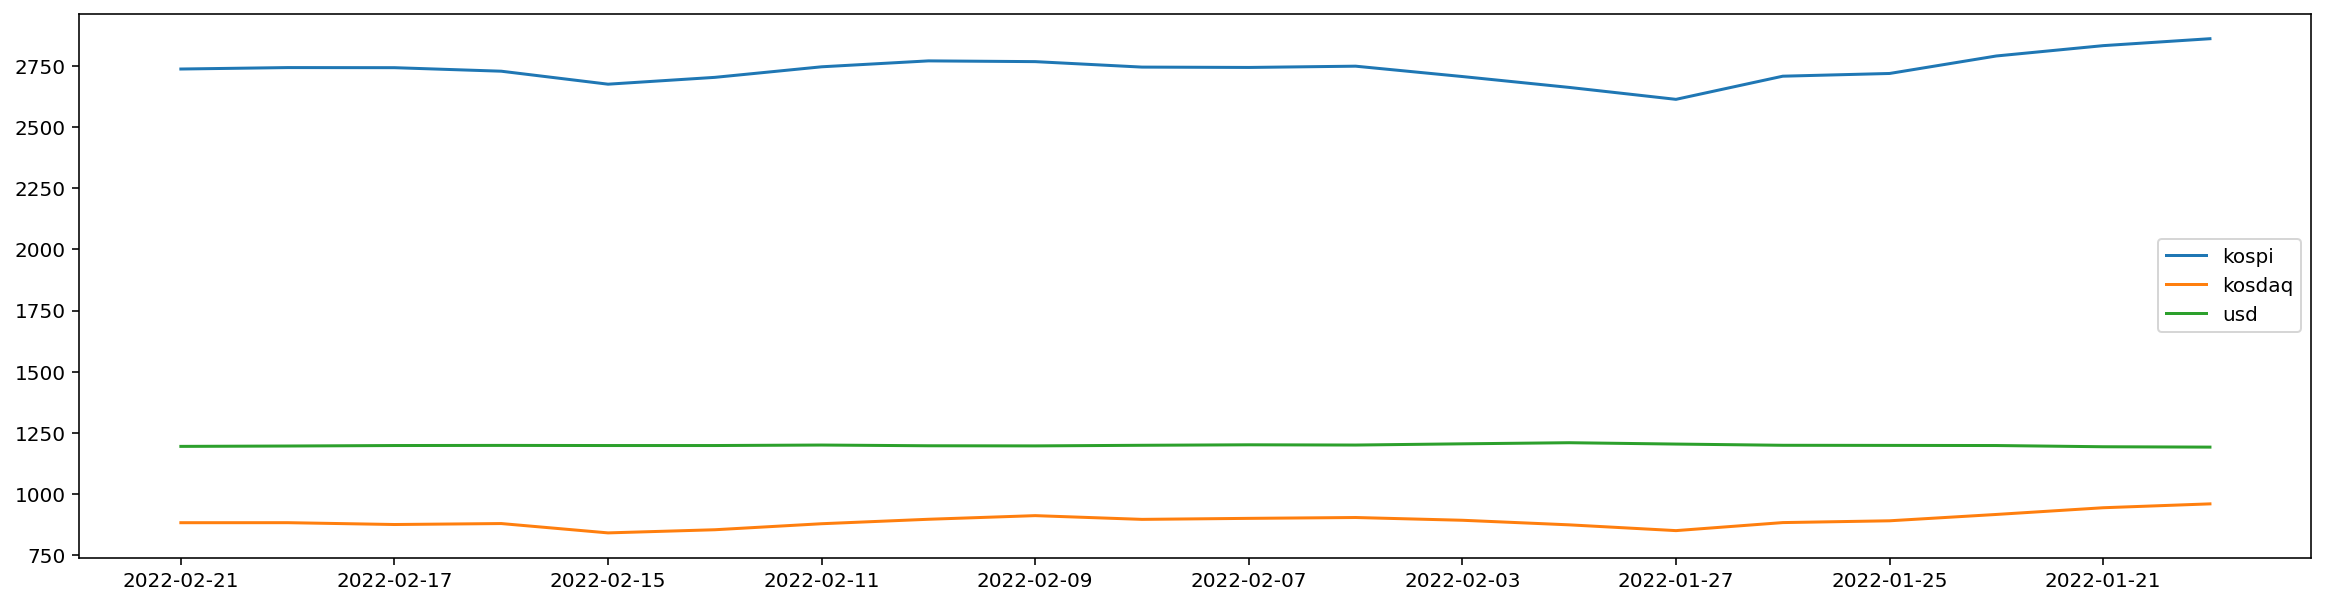

In [88]:
plt.figure(figsize=(20, 5))

# plt.plot(df["date"], df["kospi"], label="kospi")
# plt.plot(df["date"], df["kosdaq"], label="kosdaq")
# plt.plot(df["date"], df["usd"], label="usd")

for column in df.columns[1:]:
    plt.plot(df["date"], df[column], label=column)

plt.xticks(df["date"][::2])
plt.legend()
plt.show()

In [45]:
# 데이터 스케일링 : min max scale
# z = ( x - min(x) ) / ( max(x) - min(x) ) : 0 <= z <= 1

In [89]:
from sklearn.preprocessing import minmax_scale

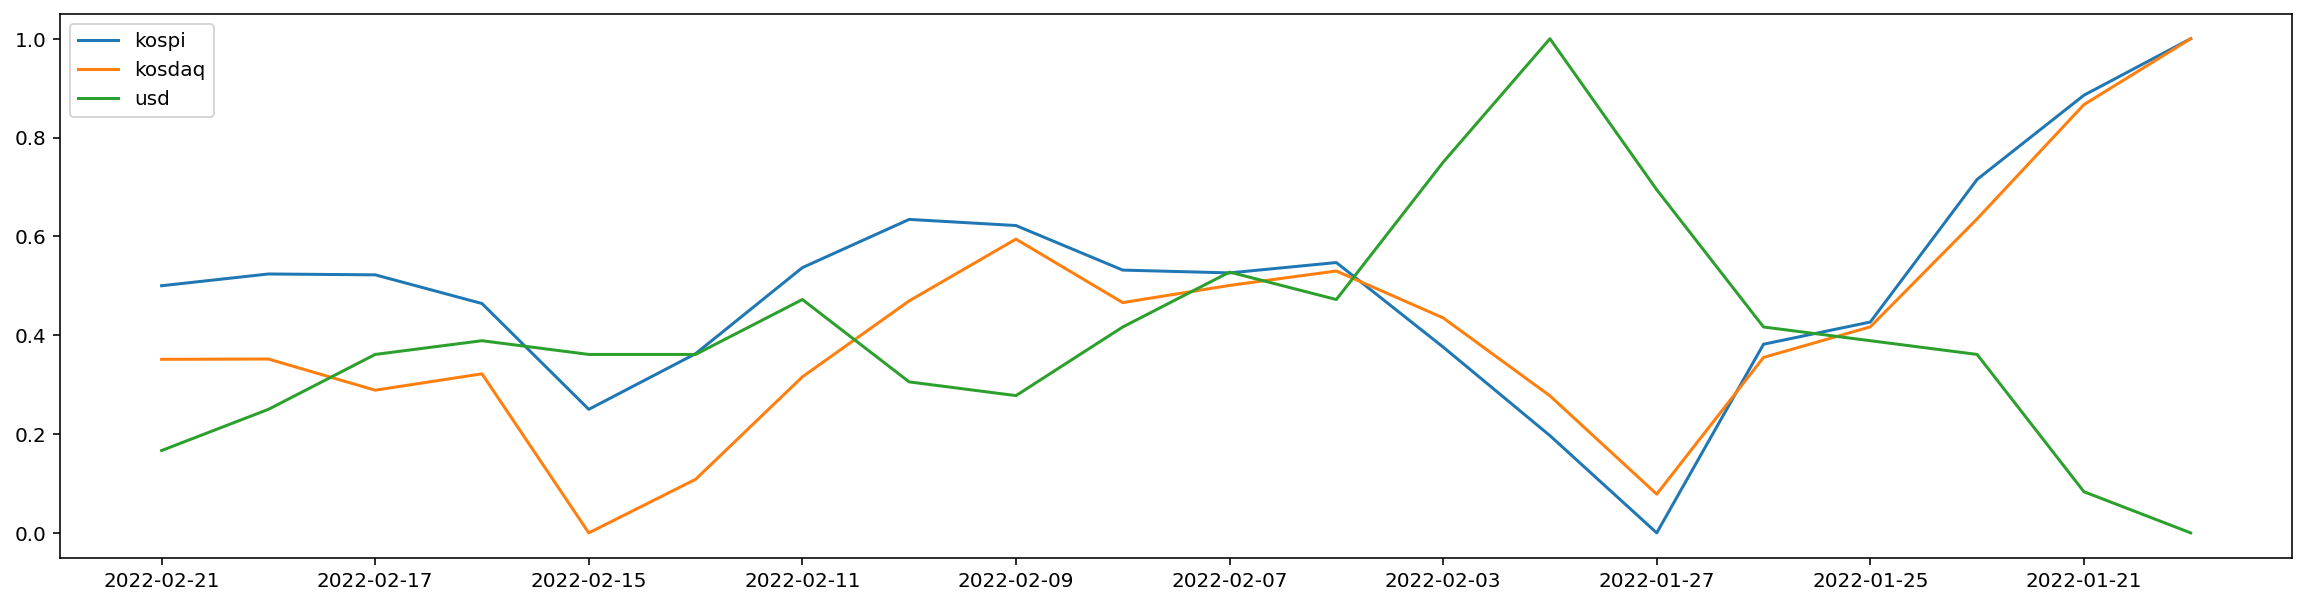

In [90]:
plt.figure(figsize=(20, 5))
for column in df.columns[1:]:
    plt.plot(df["date"], minmax_scale(df[column]), label=column)
plt.xticks(df["date"][::2])
plt.legend()
plt.show()

In [46]:
# 상관관계 분석
# 상관계수 해석
# 0과 가까울수록 두 데이터는 관계 X
# 1과 가까울수록 두 데이터는 강한 양의 상관관계
# -1과 가까울수록 두 데이터는 강한 음의 상관관계

In [ ]:
# kospi-kosdaq : 0.892 : 강한 양의 상관관계
# kospi-usd : -0.745 : 강한 음의 상관관계

In [94]:
df[df.columns[1:]].corr()

,kospi,kosdaq,usd
kospi,1.000000,0.892377,-0.745448
kosdaq,0.892377,1.000000,-0.502781
usd,-0.745448,-0.502781,1.000000
